In [3]:
import kagglehub
import pandas as pd

# Download the dataset
path = kagglehub.dataset_download("thedevastator/hate-speech-and-offensive-language-detection")
print("Path to dataset files:", path)

# Load the dataset
dataset_path = path + "/labeled_data.csv"  # Adjust the file path if needed
data = pd.read_csv('/home/atulrajput/Desktop/New Folder/program/train.csv')

# Preview the dataset
data.head()


100%|██████████| 963k/963k [00:01<00:00, 819kB/s]

Extracting files...
Path to dataset files: /home/atulrajput/.cache/kagglehub/datasets/thedevastator/hate-speech-and-offensive-language-detection/versions/2


,count,hate_speech_count,offensive_language_count,neither_count,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [4]:
# Rename and filter relevant columns
data = data[['tweet', 'class']]
data.columns = ['text', 'label']

# Map the labels: 0 = hate speech, 1 = offensive language, 2 = neither
# We'll combine "hate speech" and "offensive" into one category called "offensive"
data['label'] = data['label'].map({0: 'offensive', 1: 'offensive', 2: 'non-offensive'})

# Check the distribution of labels
print(data['label'].value_counts())


label
offensive        20620
non-offensive     4163
Name: count, dtype: int64


In [6]:
from sklearn.model_selection import train_test_split

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['label'], test_size=0.2, random_state=42)


In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

# Create a pipeline for vectorizing text and training the classifier
model = make_pipeline(CountVectorizer(), MultinomialNB())
model.fit(X_train, y_train)

# Evaluate the model
accuracy = model.score(X_test, y_test)
print("Test accuracy:", accuracy)


Test accuracy: 0.9049828525317732


In [8]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X_train, y_train, cv=5)
print("Cross-validation accuracy scores:", cv_scores)
print("Average cross-validation accuracy:", cv_scores.mean())


Cross-validation accuracy scores: [0.90443772 0.90592686 0.90290038 0.91046658 0.90945776]
Average cross-validation accuracy: 0.9066378593835751


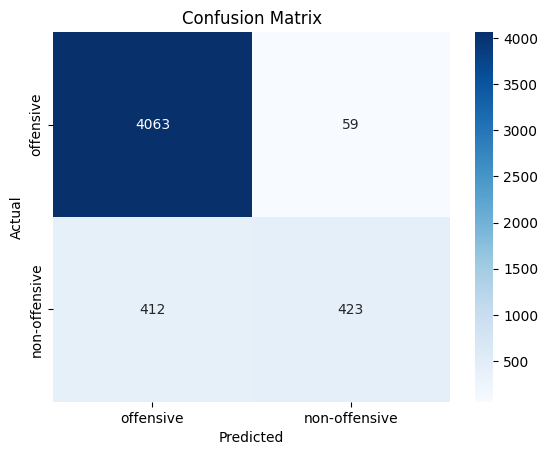

               precision    recall  f1-score   support

non-offensive       0.88      0.51      0.64       835
    offensive       0.91      0.99      0.95      4122

     accuracy                           0.90      4957
    macro avg       0.89      0.75      0.79      4957
 weighted avg       0.90      0.90      0.89      4957



In [10]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=["offensive", "non-offensive"])

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["offensive", "non-offensive"], yticklabels=["offensive", "non-offensive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_test, y_pred))


In [11]:
# Dictionary of offensive terms and positive suggestions
suggestions = {
    "stupid": "thoughtful",
    "idiot": "inexperienced",
    "hate": "dislike",
    "shut up": "please be quiet"
}

def suggest_alternative(text):
    words = text.lower().split()
    alternative_text = " ".join([suggestions.get(word, word) for word in words])
    return alternative_text


In [13]:
from textblob import TextBlob

def analyze_sentiment(text):
    # Analyze the text using TextBlob
    sentiment = TextBlob(text).sentiment
    return sentiment.polarity  # Returns a value between -1 (negative) and +1 (positive)


In [14]:
def detect_and_suggest_with_sentiment(text):
    # Predict if the text is offensive
    prediction = model.predict([text])[0]
    if prediction == 'offensive':
        print("Detected offensive language!")
        
        # Analyze sentiment to assess severity
        severity_score = analyze_sentiment(text)
        if severity_score < -0.5:
            print("Severity: High - This message has a strongly negative sentiment.")
        elif severity_score < 0:
            print("Severity: Medium - This message has a moderately negative sentiment.")
        else:
            print("Severity: Low - This message is not strongly negative.")
        
        # Suggest a positive alternative
        print("Suggested positive alternative:", suggest_alternative(text))
    else:
        print("This message is safe.")


In [15]:
# Test sentences with varying levels of severity
test_sentences = [
    "I absolutely hate everything about this!",
    "You're an idiot and a fool",
    "Thank you for being so helpful!",
    "I dislike this",
    "You are amazing!"
]

for sentence in test_sentences:
    print(f"\nOriginal: {sentence}")
    detect_and_suggest_with_sentiment(sentence)



Original: I absolutely hate everything about this!
Detected offensive language!
Severity: High - This message has a strongly negative sentiment.
Suggested positive alternative: i absolutely dislike everything about this!

Original: You're an idiot and a fool
Detected offensive language!
Severity: High - This message has a strongly negative sentiment.
Suggested positive alternative: you're an inexperienced and a fool

Original: Thank you for being so helpful!
Detected offensive language!
Severity: Low - This message is not strongly negative.
Suggested positive alternative: thank you for being so helpful!

Original: I dislike this
Detected offensive language!
Severity: Low - This message is not strongly negative.
Suggested positive alternative: i dislike this

Original: You are amazing!
Detected offensive language!
Severity: Low - This message is not strongly negative.
Suggested positive alternative: you are amazing!


In [16]:
import pickle

# Save the model
with open("model.pkl", "wb") as f:
    pickle.dump(model, f)
